<div style="color: white;">

## Model Fitting: Likelihood and Chi-Squared

Model fitting is the process of finding the best parameters for a model that describe observed data. Two commonly used statistical methods for this purpose are the **likelihood function** and the **chi-squared ($\chi^2$) statistic**. These methods quantify the agreement between the model and the data, guiding the optimization of model parameters.

---

### Key Concepts

- **Chi-Squared Statistic ($\chi^2$)**:
  - Measures the goodness-of-fit by summing the squared residuals normalized by their uncertainties:
    $$\chi^2 = \sum_i \frac{\left(y_{\text{obs},i} - y_{\text{model},i}\right)^2}{\sigma_i^2}$$
  - A smaller $\chi^2$ indicates a better fit.
  - **Reduced Chi-Squared ($\chi^2_{\text{red}}$)** accounts for degrees of freedom:
    $$\chi^2_{\text{red}} = \frac{\chi^2}{N - p}$$
    where $N$ is the number of data points and $p$ is the number of model parameters.

- **Likelihood Function ($\mathcal{L}$)**:
  - Represents the probability of observing the data given a model:
    $$\mathcal{L}(\theta) = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} \exp \left( -\frac{\left(y_{\text{obs},i} - y_{\text{model},i}(\theta)\right)^2}{2\sigma_i^2} \right)$$
  - In practice, the **log-likelihood** is maximized to simplify computations:
    $$\ln \mathcal{L}(\theta) = -\frac{1}{2} \sum_i \left[ \ln(2\pi\sigma_i^2) + \frac{\left(y_{\text{obs},i} - y_{\text{model},i}(\theta)\right)^2}{\sigma_i^2} \right]$$

---

### SED Fitting with SEDFitter

The equations above directly relate to fitting the spectral energy distributions (SEDs) of young stellar objects (YSOs):

1. **Observed Data ($y_{\text{obs},i}$)**:
   - Represents the photometric fluxes of YSOs measured in various filters (e.g., Gaia, 2MASS, WISE).
   - These fluxes are the input data for the fitting process.

2. **Model Predictions ($y_{\text{model},i}$)**:
   - Represent the theoretical fluxes predicted by the SED models for specific physical parameters, such as stellar temperature, disk mass, and extinction.
   - The models are pre-computed and convolved with the same filter response functions as the observations.

3. **Uncertainties ($\sigma_i$)**:
   - Correspond to the photometric errors associated with the observed fluxes.
   - These uncertainties weigh the residuals in both $\chi^2$ and likelihood calculations, emphasizing data points with smaller errors.

In this notebook, we will use **SEDFitter** to implement this framework. By minimizing the $\chi^2$ statistic or maximizing the likelihood function, we aim to identify the best-fitting models for the observed SEDs of YSOs. This allows us to infer their physical properties, such as the size and temperature of their central stars, the structure and mass of their circumstellar disks, and the level of extinction in their surrounding environment.

</div>

<div style="color: #FF4500;">

## Installing SEDFitter
Instructions to download SEDFitter are available here: [SEDFitter Installation](https://sedfitter.readthedocs.io/en/stable/installation.html)

## Downloading the SED Models
SEDFitter only includes the code to perform the model fitting, not the models themselves. We will be using the SED models from this paper: [SED Models Paper](https://arxiv.org/abs/1703.05765)

- Navigate to the following data repository: [Zenodo Repository](https://zenodo.org/records/166732)
- Scroll and click on the file 'sp--s-i.tar.gz' (this will download to your computer).
- Go to the location on your computer where the file downloaded.
- Double click on the file so that it unzips/untars.
- You should now have a folder titled 'sp--s-i' that contains `models.conf`, `parameters.fits`, `stellar.fits`, `flux.fits`, and a sub-directory titled 'convolved'.

</div>

In [1]:
# After installing SEDFitter, you will also need to PIP install the following packages:
# run: pip install pandas 

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# NOTE: Cell can be ignored if you have a CSV file with the data

hdu = fits.open('/Users/cam/Downloads/asu-50.fit')
d = hdu[1].data
df_orion = pd.DataFrame(d)

coords = SkyCoord(
    ra=df_orion['RAJ2000'], 
    dec=df_orion['DEJ2000'], 
    unit=(u.hourangle, u.deg), 
    frame='icrs'
)

# Extract RA and Dec in decimal degrees
df_orion['ra'] = coords.ra.deg
df_orion['dec'] = coords.dec.deg
df_orion['l'] = coords.galactic.l.deg
df_orion['b'] = coords.galactic.b.deg

columns_good = ['ra', 'dec', 'l', 'b', 'Jmag', 'Hmag', 'Ksmag', 'W1', 'W2', 'W3', 'W4', 'Class'] + [col for col in df_orion.columns if col.startswith('alpha')]
df = df_orion[columns_good]
df['name'] = ['star_' + str(i) for i in range(len(df))]

df = df.rename(columns={
    'W1': 'W1mag', 
    'W2': 'W2mag',
    'W3': 'W3mag',
    'W4': 'W4mag'
})

df.to_csv('/Users/cam/Downloads/orionA_stars.csv', index=False)

## Read in the data file: 'orion_stars.csv'
Data comes from Großschedl et al. 2019: https://www.aanda.org/articles/aa/abs/2019/02/aa32577-18/aa32577-18.html

In [3]:
path_to_data = '/Users/cam/Downloads/orionA_stars.csv' # Change this to the path of the data file you have downloaded
df = pd.read_csv(path_to_data)

# Plot stars on extinction map of Orion

In [4]:
# hdu = fits.open('/Users/cam/Downloads/planck_herschel.fits')
# h = hdu[0].header
# d = hdu[0].data[0,:,:].astype(np.float64)

# plt.figure()
# plt.imshow(d, origin='lower')
# plt.show()

# Preparing the Data
Below we must prepare our data in a specific format specified by SEDFitter, specified here: https://sedfitter.readthedocs.io/en/stable/data.html

This requires us to convert our magnitudes to fluxes, in units of milli-Janskys (mJy): https://en.wikipedia.org/wiki/Jansky

In [5]:
other_cols = ['name', 'ra', 'dec']
filters_mags = [
    'Jmag', 'Hmag', 'Ksmag',
    'W1mag', 'W2mag', 'W3mag', 'W4mag'
]
filter_names = [
    'J', 'H', 'Ks',
    'W1', 'W2', 'W3', 'W4'
]
# Effective wavelengths (in microns) for each filter
wavelengths = np.array([
    1.235,  # 2MASS J band
    1.662,  # 2MASS H band
    2.159,  # 2MASS Ks band
    3.4,    # WISE W1
    4.6,    # WISE W2
    12.0,   # WISE W3
    22.0    # WISE W4
])

In [6]:
# Function to compute the flux density from the magnitude

# Zero-point flux densities in Jy for each filter
zero_point_fluxes = np.array([
    1594,  # 2MASS J band (Jmag)
    1024,  # 2MASS H band (Hmag)
    666.7, # 2MASS Ks band (Ksmag)
    309.54, # WISE W1 band
    171.79, # WISE W2 band
    31.674, # WISE W3 band
    8.363  # WISE W4 band
])

# Function to convert magnitude to flux
def mag_to_flux(mag, zero_point):
    if np.isnan(mag):  # Handle NaNs gracefully
        return np.nan
    return (zero_point * 10**(-0.4 * mag))*1000

# Convert magnitudes to flux densities and compute errors
for filter_name, filter_mag, zero_point in zip(filter_names, filters_mags, zero_point_fluxes):
    flux_col_name = f"{filter_name}_flux"
    flux_err_col_name = f"{filter_name}_flux_err"
    
    # Compute flux
    df[flux_col_name] = df[filter_mag].apply(lambda mag: mag_to_flux(mag, zero_point))
    
    # Compute flux error (10% of flux)
    df[flux_err_col_name] = df[flux_col_name] * 0.10

In [7]:
for fn in filter_names:
    df['{}_flag'.format(fn)] = df['{}mag'.format(fn)].apply(lambda x: int(1) if pd.notnull(x) and x != 0 else int(0))

In [8]:
fluxes = df[[f"{filter_name}_flux" for filter_name in filter_names]].values
flux_errors = df[[f"{filter_name}_flux_err" for filter_name in filter_names]].values

In [9]:
wavelengths

array([ 1.235,  1.662,  2.159,  3.4  ,  4.6  , 12.   , 22.   ])

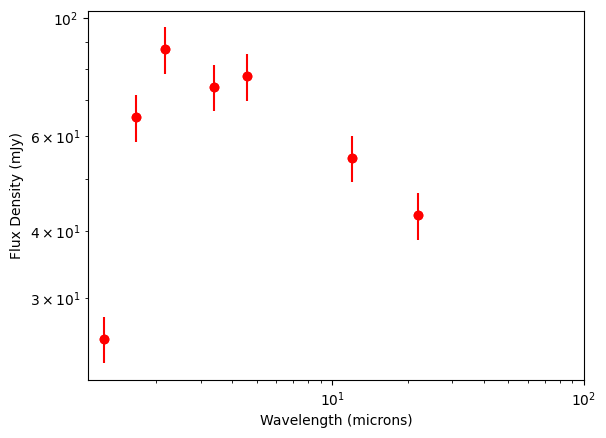

In [10]:
# Plot an example SED
star = df.loc[df.name == 'star_10']
valid_fluxes = star[[f"{filter_name}_flux" for filter_name in filter_names]].values[0]
valid_flux_errors = star[[f"{filter_name}_flux_err" for filter_name in filter_names]].values[0]
valid_flags = star[[f"{filter_name}_flag" for filter_name in filter_names]].values[0]

# Filter out fluxes where the flag is 0
valid_wavelengths = wavelengths[valid_flags == 1]
valid_fluxes = valid_fluxes[valid_flags == 1]
valid_flux_errors = valid_flux_errors[valid_flags == 1]

plt.figure()
plt.scatter(valid_wavelengths, valid_fluxes, c='r')
plt.errorbar(valid_wavelengths, valid_fluxes, yerr=valid_flux_errors, fmt='o', c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux Density (mJy)')
plt.xlim(-100, 100)
plt.show()

In [11]:
# Create a list of columns in the desired order
all_cols = list(df.columns)
cols_format = ['name', 'ra', 'dec'] + list(df.columns[df.columns.str.endswith('_flag')])
for filter_name in filter_names:
    cols_format.append(f"{filter_name}_flux")
    cols_format.append(f"{filter_name}_flux_err")

# Reorder the dataframe
df_fmt = df[cols_format]

In [12]:
#stars = df_fmt.iloc[0:20] # run on only the first 20 stars, good for testing
stars = df_fmt
stars.to_csv('stars', sep=' ', index=False, header=False) # Save to a new file in the desired format for SEDFitter

In [13]:
from astropy import units as u
from sedfitter import fit
from sedfitter.extinction import Extinction

# Define path to models
model_dir = '/Users/cam/Downloads/sp--s-i/'
#model_dir = '/Users/cam/Downloads/sp--smi/'
extinction_file = '/Users/cam/Downloads/kmh94.par'

# Read in extinction law)
extinction = Extinction.from_file(extinction_file, columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Run the Fitter

In [ ]:
# Define filters and apertures
filters = ['2J', '2H', '2K', 'WISE1', 'WISE2', 'WISE3', 'WISE4'] 
#apertures = [4., 4., 4., 8., 8., 16., 22.] * u.arcsec
apertures = [3., 3., 3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
fit('stars', filters, apertures, model_dir,
    'output.fitinfo',
    extinction_law=extinction,
    distance_range=[0.1, .6] * u.kpc,
    av_range=[0., 40.])

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  sp--s-i
   Log[d] stepping     :  0.02
   Number of distances :  40

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 40, 7).  use_memmap=True
   Reading /Users/cam/Downloads/sp--s-i//convolved/2J.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/2H.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/2K.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE1.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE2.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE3.fits
   Reading /Users/cam/Downloads/sp--s-i//convolved/WISE4.fits
 ------------------------------------------------------------
  => Fitting parameters
 --------------------------------------------

In [ ]:
# from sedfitter import plot
# plot(
#     input_fits = 'output.fitinfo', 
#     output_dir = 'plots_seds'
#     #select_format = ('A', 6)
#     )

In [ ]:
from sedfitter import write_parameters, write_parameter_ranges
# Write out all models with a delta chi^2-chi_best^2 per datapoint < 3
# Write out the min/max ranges corresponding to the above file
write_parameter_ranges('output.fitinfo', 'parameter_ranges.txt',
                       select_format=('F', 3.))

In [ ]:
from astropy.io import ascii

# File path
file_path = "parameter_ranges.txt"

# Read the file with Astropy, skipping problematic parts
data = ascii.read(
    file_path,
    format="basic",  # Basic ASCII format
    guess=False,     # Don't guess the format
    header_start=1,  # Line index for the main header (second header)
    data_start=3     # Line index for the data (after dashed lines)
)

# Convert to Pandas DataFrame for further analysis if needed
df_params = data.to_pandas()

In [ ]:
param_names = ['chi2', 'av', 'scale', 'star.radius', 'star.temperature', 'disk.mass', 'disk.rmax', 'disk.beta', 'disk.p', 'disk.h100', 'scattering', 'inclination']
for i, param_name in enumerate(param_names):
    if i == 0:
        df_params.rename(columns={
            'min': f'{param_name}_min',
            'best': f'{param_name}_best',
            'max': f'{param_name}_max'
        }, inplace=True)
    else:
        df_params.rename(columns={
            f'min_{i}': f'{param_name}_min',
            f'best_{i}': f'{param_name}_best',
            f'max_{i}': f'{param_name}_max'
        }, inplace=True)

In [ ]:
df_final = pd.merge(stars, df_params, left_index=True, right_index=True, suffixes=('', '_y'))
df_final = df_final.loc[:, ~df_final.columns.str.endswith('_y')]
df_final.to_csv('final_results.csv', index=False)

In [ ]:
df_final

,name,ra,dec,J_flag,H_flag,Ks_flag,W1_flag,W2_flag,W3_flag,W4_flag,...,disk.p_max,disk.h100_min,disk.h100_best,disk.h100_max,scattering_min,scattering_best,scattering_max,inclination_min,inclination_best,inclination_max
0,star_0,82.347337,-4.515666,1,1,1,1,1,1,1,...,-0.011210,1.010,1.733,19.180,1.0,1.0,1.0,0.271900,79.21,88.40
1,star_1,82.503129,-5.262536,1,1,1,1,1,1,1,...,-0.009517,1.208,4.301,19.790,1.0,1.0,1.0,0.315100,65.63,87.92
2,star_2,82.620921,-3.945233,1,1,1,1,1,1,1,...,-0.000303,1.001,2.639,19.370,1.0,1.0,1.0,0.001874,28.86,88.39
3,star_3,82.627467,-4.413928,1,1,1,1,1,1,1,...,-0.008574,1.006,1.391,19.890,1.0,1.0,1.0,0.007643,76.09,88.71
4,star_4,82.660021,-5.428783,1,1,1,1,1,1,1,...,-0.000303,1.001,18.350,19.740,1.0,1.0,1.0,0.052140,43.44,89.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900,star_2900,85.627212,-10.179893,1,1,1,1,1,1,1,...,-0.009517,1.009,3.080,19.970,1.0,1.0,1.0,0.018590,19.97,86.87
2901,star_2901,85.847292,-7.476228,1,1,1,1,1,1,1,...,-0.000045,1.001,1.453,20.000,1.0,1.0,1.0,0.001874,62.49,89.99
2902,star_2902,85.627567,-8.548665,1,1,1,1,1,1,1,...,-0.020360,1.006,6.688,19.740,1.0,1.0,1.0,0.114100,55.50,85.90
2903,star_2903,85.628067,-9.884145,1,1,1,1,1,1,1,...,-0.001151,1.008,3.091,19.850,1.0,1.0,1.0,0.023910,56.47,87.60


In [ ]:
for k in df_final.keys():
    print(k)

name
ra
dec
J_flag
H_flag
Ks_flag
W1_flag
W2_flag
W3_flag
W4_flag
J_flux
J_flux_err
H_flux
H_flux_err
Ks_flux
Ks_flux_err
W1_flux
W1_flux_err
W2_flux
W2_flux_err
W3_flux
W3_flux_err
W4_flux
W4_flux_err
source_name
n_data
n_fits
chi2_min
chi2_best
chi2_max
av_min
av_best
av_max
scale_min
scale_best
scale_max
star.radius_min
star.radius_best
star.radius_max
star.temperature_min
star.temperature_best
star.temperature_max
disk.mass_min
disk.mass_best
disk.mass_max
disk.rmax_min
disk.rmax_best
disk.rmax_max
disk.beta_min
disk.beta_best
disk.beta_max
disk.p_min
disk.p_best
disk.p_max
disk.h100_min
disk.h100_best
disk.h100_max
scattering_min
scattering_best
scattering_max
inclination_min
inclination_best
inclination_max


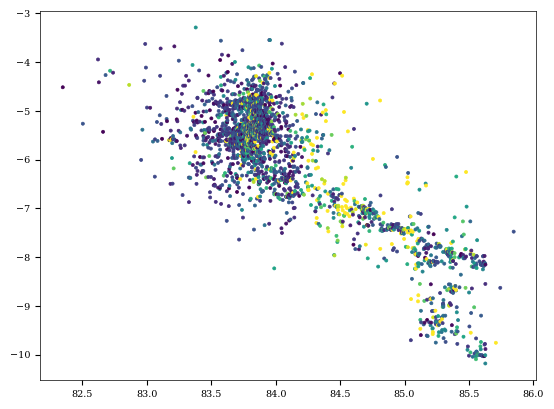

In [ ]:
plt.figure()
plt.scatter(df_final.ra, df_final.dec, c=df_final['av_best'], s = 5, vmax = 20)
plt.show()

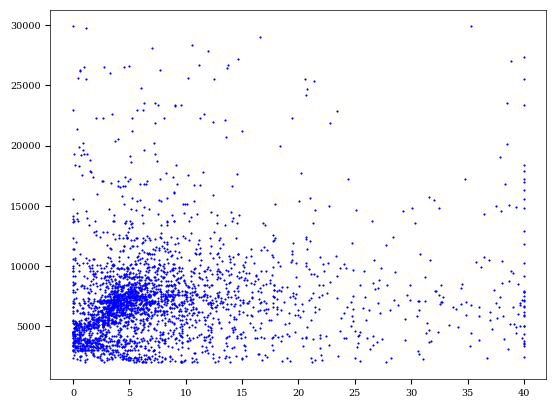

In [ ]:
plt.figure()
plt.scatter(df_final['av_best'], df_final['star.temperature_best'], c='blue', s = 1)
plt.show()